In [1]:
import sys
from from_root import from_root

sys.path.insert(0, str(from_root("src")))

from read_and_write_docs import read_rds

In [25]:
corpora = ["Wiki", "Enron", "Perverted Justice", "StackExchange",
            "ACL", "The Apricity", "Koppel's Blogs",
            "The Telegraph", "Reddit"]

In [26]:
n_gram_df = read_rds('/Volumes/BCross/av_datasets_experiments/Baseline Results/n_gram_tracing_calibrated_performance.rds')
n_gram_df = n_gram_df[n_gram_df['corpus'].isin(corpora)]

lambdag_df = read_rds('/Volumes/BCross/av_datasets_experiments/Baseline Results/lambdag_calibrated_performance.rds')

In [27]:
lambdag_df

,corpus,Cllr,Cllr_min,EER,Mean TRUE LLR,Mean FALSE LLR,TRUE trials,FALSE trials,AUC,Balanced Accuracy,Precision,Recall,F1,TP,FN,FP,TN
0,Wiki,0.655020,0.596380,22.807018,4.171571,-1.948630,114.0,114.0,0.861647,0.781250,0.846154,0.687500,0.758621,77,35,14,98
1,Enron,0.495498,0.373682,14.000000,5.933745,-2.021982,50.0,50.0,0.929470,0.875000,0.928571,0.812500,0.866667,39,9,3,45
2,Perverted Justice,0.662823,0.540876,19.620253,2.373232,-4.203088,158.0,158.0,0.893471,0.785256,0.900901,0.641026,0.749064,100,56,11,145
3,StackExchange,0.782830,0.589207,20.689655,0.504932,-0.438523,116.0,116.0,0.867190,0.793860,0.741007,0.903509,0.814229,103,11,36,78


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

def _order_n_cats(cats):
    """Sort numeric n ascending; put non-numeric after; 'None' last."""
    def key(x):
        x = str(x)
        if x.lower() == "none":
            return (2, float("inf"))
        try:
            return (0, float(x))
        except ValueError:
            return (1, x)
    return sorted(pd.unique([str(c) for c in cats]), key=key)

def facet_metric_vs_n_by_corpus(
    df,
    *,
    x_col="n",
    y_col="balanced_accuracy",
    facet_col="corpus",
    group_col="coefficient",
    agg_fn="mean",
    ncols=3,
    sharey=True,
    title=None,
    legend=True,
):
    """
    Facet wrap by corpus (one subplot per corpus).
    X: n (as categorical: "2", "3", ...; missing -> "None")
    Y: y_col (e.g., balanced_accuracy)
    Lines: coefficient
    """
    d = df.copy()

    # Required columns
    for col in [x_col, y_col, facet_col, group_col]:
        if col not in d.columns:
            raise ValueError(f"Missing '{col}' in df.")

    # Build x categorical labels from x_col
    def _to_n_cat(v):
        if pd.isna(v):
            return "None"
        try:
            fv = float(v)
            return str(int(fv)) if fv.is_integer() else str(fv)
        except Exception:
            return str(v)

    d["n_cat"] = d[x_col].map(_to_n_cat)

    # Aggregate in case multiple rows per (corpus, coefficient, n)
    grp = d.groupby([facet_col, group_col, "n_cat"], dropna=False)[y_col]
    if agg_fn == "mean":
        plot_df = grp.mean().reset_index()
    elif agg_fn == "median":
        plot_df = grp.median().reset_index()
    else:
        raise ValueError("agg_fn must be 'mean' or 'median'")

    # Global ordered x-axis across all facets
    x_order = _order_n_cats(plot_df["n_cat"])
    x_pos = np.arange(len(x_order))
    x_index = {lab: i for i, lab in enumerate(x_order)}

    # Facets = corpora
    facet_vals = sorted(plot_df[facet_col].dropna().unique())
    n_facets = len(facet_vals)
    nrows = ceil(n_facets / ncols)

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(4.8 * ncols, 3.6 * nrows),
        sharex=True,
        sharey=sharey,
    )
    axes = np.array(axes).reshape(-1)

    legend_handles = None
    legend_labels = None

    for i, fac in enumerate(facet_vals):
        ax = axes[i]
        sub_fac = plot_df[plot_df[facet_col] == fac]

        for g in sorted(sub_fac[group_col].dropna().unique()):
            sub_g = sub_fac[sub_fac[group_col] == g]

            y = np.full(len(x_order), np.nan, dtype=float)
            for _, r in sub_g.iterrows():
                y[x_index[r["n_cat"]]] = float(r[y_col])

            ax.plot(x_pos, y, marker="o", linewidth=2, label=f"{group_col}={g}")

        ax.set_title(str(fac))
        ax.grid(True, alpha=0.3)
        ax.set_ylabel(y_col)

        if legend and legend_handles is None:
            legend_handles, legend_labels = ax.get_legend_handles_labels()

    # Turn off unused axes
    for j in range(n_facets, len(axes)):
        axes[j].axis("off")

    # X ticks/labels
    for ax in axes[:n_facets]:
        ax.set_xticks(x_pos)
        ax.set_xticklabels(x_order)

    # X label only on bottom row
    for ax in axes[(nrows - 1) * ncols : nrows * ncols]:
        if ax.has_data():
            ax.set_xlabel(x_col)

    # Shared legend
    if legend and legend_handles:
        fig.legend(
            legend_handles,
            legend_labels,
            loc="upper center",
            bbox_to_anchor=(0.5, 1.02),
            ncol=min(len(legend_labels), 6),
            frameon=False,
        )

    if title:
        fig.suptitle(title, y=1.08 if legend else 1.02)

    plt.tight_layout()
    return fig, axes[:n_facets]

# Example:
# fig, axes = facet_metric_vs_n_by_corpus(df, y_col="balanced_accuracy", title="Balanced accuracy vs n")
# plt.show()

<positron-console-cell-29>:16: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


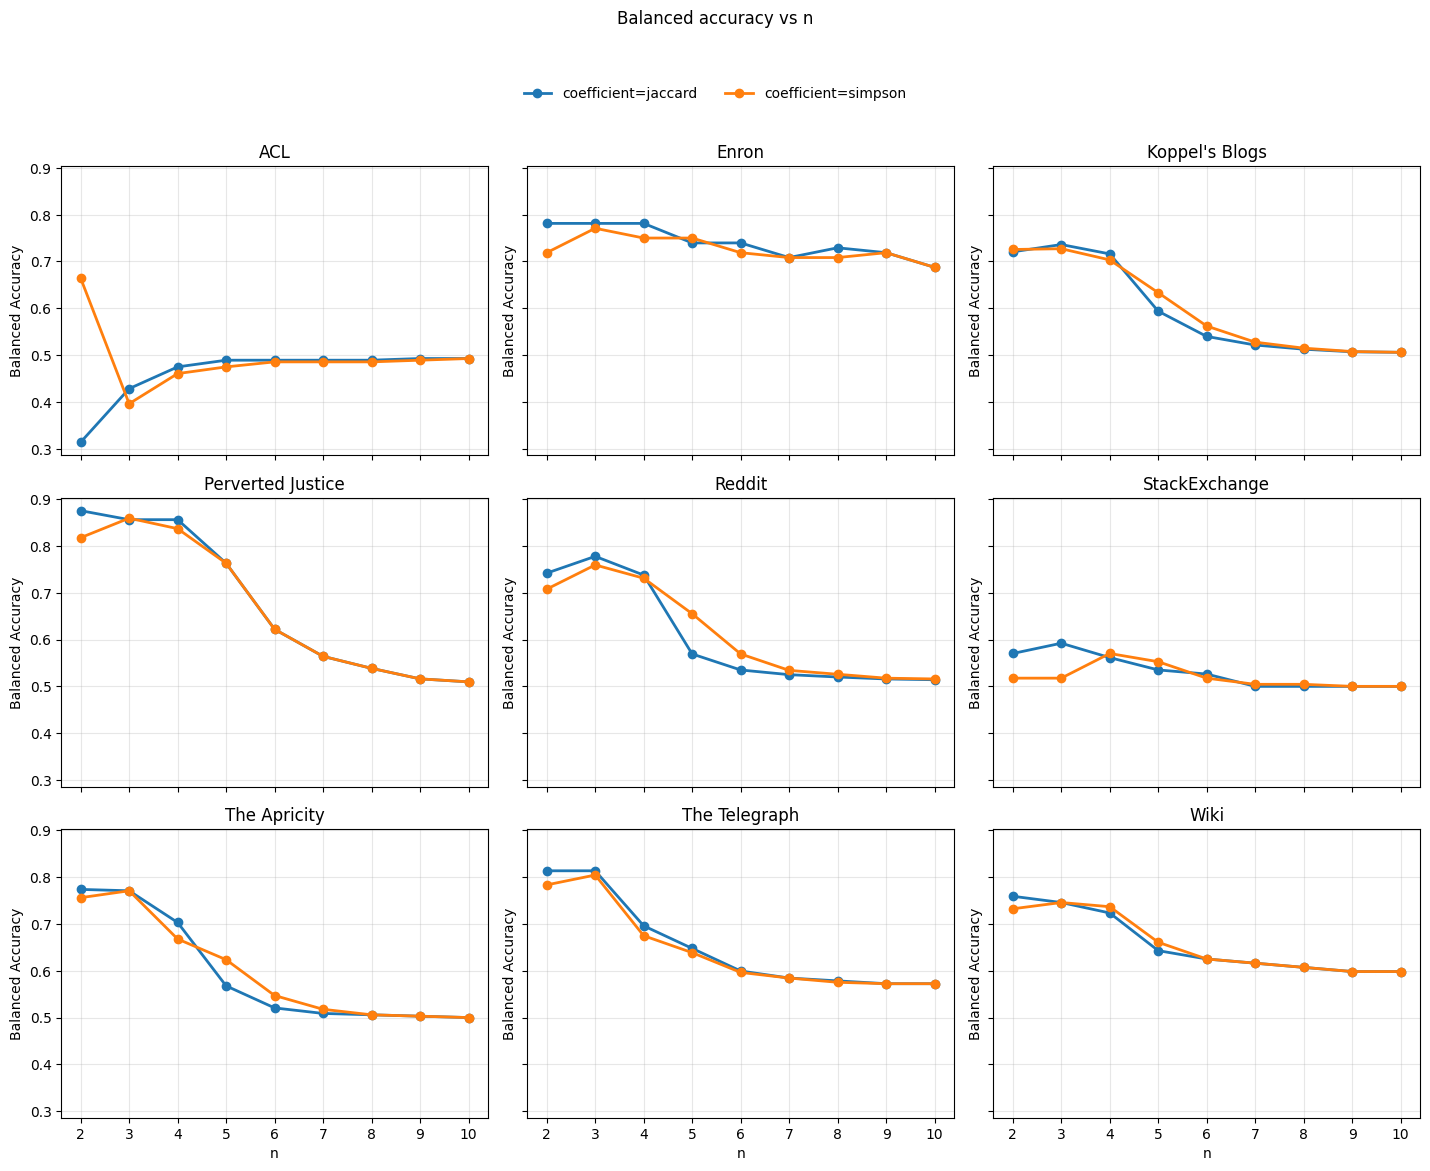

In [29]:
fig, axes = facet_metric_vs_n_by_corpus(n_gram_df, y_col="Balanced Accuracy", title="Balanced accuracy vs n")
plt.show()

In [31]:
n_gram_df_filtered = (
    n_gram_df[
        (n_gram_df["coefficient"] == "simpson") &
        (n_gram_df["n"].isin([2, 3]))
    ]
    .drop(columns=["coefficient"])
)

In [32]:
n_gram_df_filtered

,corpus,n,Cllr,Cllr_min,EER,Mean TRUE LLR,Mean FALSE LLR,TRUE trials,FALSE trials,AUC,Balanced Accuracy,Precision,Recall,F1,TP,FN,FP,TN
9,Wiki,2,0.724600,0.671500,25.328947,1.411878,-0.582490,114.0,114.0,0.831912,0.732143,0.724138,0.750000,0.736842,84,28,32,80
10,Wiki,3,0.675745,0.635757,24.400585,3.950276,-0.796713,114.0,114.0,0.851921,0.745536,0.808989,0.642857,0.716418,72,40,17,95
27,Enron,2,0.674599,0.594281,24.000000,1.865961,-0.624510,50.0,50.0,0.848741,0.718750,0.714286,0.729167,0.721649,35,13,14,34
28,Enron,3,0.667410,0.630396,24.375000,4.381666,-0.646758,50.0,50.0,0.839410,0.770833,0.825000,0.687500,0.750000,33,15,7,41
45,Perverted Justice,2,0.598955,0.538698,18.618143,1.575250,-1.348751,158.0,158.0,0.883773,0.817308,0.856115,0.762821,0.806780,119,37,20,136
46,Perverted Justice,3,0.516180,0.477323,14.285714,3.967565,-1.661420,158.0,158.0,0.911592,0.858974,0.917910,0.788462,0.848276,123,33,11,145
63,StackExchange,2,1.001791,0.974878,45.434483,0.002938,-0.040811,116.0,116.0,0.533972,0.517544,0.518182,0.500000,0.508929,57,57,53,61
64,StackExchange,3,0.999413,0.986139,45.922997,0.050572,0.007984,116.0,116.0,0.543475,0.517544,0.517857,0.508772,0.513274,58,56,54,60
81,ACL,2,0.997915,0.860364,33.292861,-0.000506,-0.006329,142.0,142.0,0.703316,0.664286,0.767442,0.471429,0.584071,66,74,20,120
82,ACL,3,1.004329,1.000000,50.000000,0.007711,0.019509,142.0,142.0,0.745408,0.396429,0.441767,0.785714,0.565553,110,30,139,1
